In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
S_PREFIX = '29-weights'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
#         self.sz = self.get_sz()
        
#     def get_sz(self): return self.transform.sz
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
# x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
# y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))
x_names_test = np.array(glob(f'../data/TestData/CameraRGB/*.png'))

In [59]:
def convert_y_old(y_img):
    print('Y_img:', y_img.shape)
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
#     cutoff_y = int(y_new.shape[0]*.83) # Use this value for before crop_bg_pil
    cutoff_y = int(y_new.shape[0]*.87)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS | y_img==ROAD_LINES]
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()


def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.87)
    yc[cutoff_y:,:] = 0
    yn = ~(yc | yr)
    return torch.from_numpy(np.stack((yn,yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [18]:
files = glob(f'../data/all/CameraSeg-150/*.png')

In [34]:
len(files)

4600

In [77]:
y_img = cv2.imread(files[0])[:,:,2]

In [78]:
y_img.shape

(150, 200)

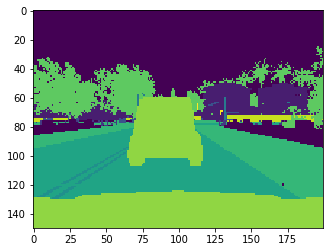

In [93]:
plt.imshow(cv2.imread(files[0])[:,:,2])

In [107]:
h, w = y_img.shape
top = int(h/3.75)
bot = int(h*.9 + h/150)
pad_right=32-w%32

In [113]:
TTF.crop(x, top, 0, bot-top, w+pad_right)
test = y_img[top:bot, :]

In [114]:
top

40

In [115]:
bot

136

In [116]:
test.shape

(96, 200)

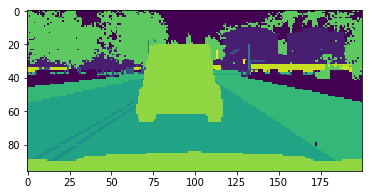

In [117]:
plt.imshow(test)

In [82]:
np.mean(y_img)

5.202933333333333

In [122]:
150*.83 - h/3.75

84.5

In [129]:
96*.87

83.52

In [123]:
84.5/96

0.8802083333333334

In [103]:
96*.83

79.67999999999999

In [138]:
y_img = test

In [139]:
yr = (y_img==ROADS) | (y_img==ROAD_LINES)

In [160]:
yc = (y_img==VEHICLES)

In [161]:
cutoff_y = int(yc.shape[0]*.87)

In [162]:
yc[cutoff_y:,:] = 0

In [163]:
yr.shape

(96, 200)

In [164]:
yc.dtype

dtype('bool')

In [165]:
yr.dtype

dtype('bool')

In [168]:
np.mean(~(yc | yr))

0.6360416666666666

In [181]:
np.stack((yr,yc)).astype(float)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

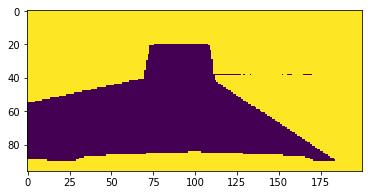

In [170]:
plt.imshow((~(yc | yr)).astype(float))

In [19]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [20]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))
    x_names_test = np.sort(np.array(glob(f'../data/TestData/CameraRGB{f_ext}/*.png')))
    y_names_test = np.sort(np.array(glob(f'../data/TestData/CameraSeg{f_ext}/*.png')))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    x_all = np.concatenate((x_names, x_names_test))
    y_all = np.concatenate((y_names, y_names_test))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_all, y_all)
    print(f'Valx: {len(val_x)}, Valy: {len(val_y)}')
    print(f'Trnx: {len(trn_x)}, Trny: {len(trn_y)}')
    print(f'Testx: {len(x_names_test)}')
    print(f'Allx: {len(x_names)}')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [21]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

In [22]:
sz = 96
bs = 2
data = torch_loader('-150', PATH, bs, sz)

Valx: 300, Valy: 300
Trnx: 4300, Trny: 4300
Testx: 0
Allx: 4600


In [30]:
x,y = data.trn_ds[800]

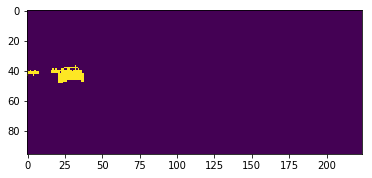

In [31]:
plt.imshow(y[1])

In [154]:
x.shape

torch.Size([3, 96, 224])

In [155]:
y.shape

torch.Size([2, 96, 224])

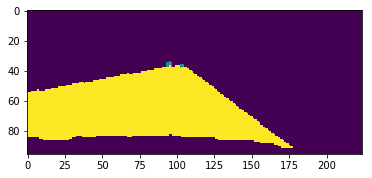

In [120]:
plt.imshow(y)

In [24]:
x.shape, y.float().mean()

(torch.Size([3, 96, 224]), 0.5407831101190477)

In [25]:
x_out = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


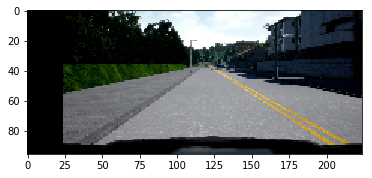

In [26]:
plt.imshow(x_out)

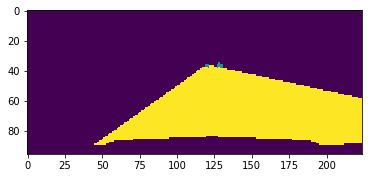

In [27]:
plt.imshow(y)

## U-net (ish)

In [33]:
from torchvision.models import vgg11_bn

In [34]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [35]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [91]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(False), cut)
    return nn.Sequential(*layers), lr_cut

In [92]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [93]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [94]:
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [95]:
class Unet16(nn.Module):
    def __init__(self, f=vgg11_bn):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [5,12,22,32,42]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5  = nn.Conv2d(256,3,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [41]:
class Unet11(nn.Module):
    def __init__(self, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5  = nn.Conv2d(256,3,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [42]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [43]:
def car_f_p_r(pred, targs):
    mx,idx = torch.max(pred, 1)
    return fbeta_score(targs==1, idx==1, 2)

In [44]:
def rd_f(pred, targs):
    mx,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(targs==2, idx==2, 0.5)
    return f

In [45]:
def non_f(pred, targs):
    mx,idx = torch.max(pred, 1)
    return fbeta_score(targs==0, idx==0, 1)

In [46]:
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)

def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    p2 = F.sigmoid(preds)
    return ((p2>0.5).long() == targs).float().mean()

def fbeta_score(y_true, y_pred, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [47]:
def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
#     num = pred.size(0)
    m1 = pred.view(num, 3, -1)  # Flatten
    m2 = target.view(num, 3, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        num = targets.size(0)  # Number of batches

#         score = dice_coeff(probs, targets)
        score = dice_coeff(probs, targets.float())
        score = 1 - score.sum() / num
        return score

In [48]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [96]:
def get_learner(md, m_fn=Unet34):
#     m = to_gpu(Unet34())
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.FloatTensor([1,3,2]).cuda()
    learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss()
#     learn.crit=nn.CrossEntropyLoss()
#     learn.crit=FocalLoss(2)
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc]
#     learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

In [100]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

# ext = ''
# sz=384
# bs=24
# md = torch_loader(ext, PATH, bs, sz)
ext = '-150'
sz = 96
bs = 64
md = torch_loader(ext, PATH, bs, sz, random_crop=True)

learn = get_learner(md)

Valx: 300, Valy: 300
Trnx: 4300, Trny: 4300
Testx: 0
Allx: 4600


In [101]:
learn.load('600urn-19-weights-26-r8')

In [102]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    p2 = F.sigmoid(preds)
    return ((p2>0.5).long() == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [84]:
%pdb on

Automatic pdb calling has been turned ON


In [104]:
learn.fit(1e-2,1,cycle_len=10)

epoch      trn_loss   val_loss   new_acc                   
    0      0.983818   0.98359    0.991289  
    1      0.983258   0.983498   0.99392                   
    2      0.983105   0.983476   0.994645                  
    3      0.98308    0.983557   0.991395                  
    4      0.983071   0.983473   0.994665                  
    5      0.983051   0.983471   0.994711                  
    6      0.983058   0.983471   0.994704                  
    7      0.983043   0.983468   0.994829                  
    8      0.983051   0.983468   0.994825                  
    9      0.983049   0.983469   0.994778                  



[array([0.98347]), 0.9947781793276469]

In [53]:
crit = SoftDiceLoss()

it_trn = iter(md.trn_dl)

x,y = next(it_trn)

preds = learn.model(VV(x))

crit(preds, VV(y))

probs = F.sigmoid(preds)

it = probs * VV(y).float()

num = x.shape[0]


m1 = probs.view(num, 3, -1)  # Flatten
m2 = VV(y).float().view(num, 3, -1)  # Flatten

(m1 * m2).shape

In [40]:
# learn.half()

In [43]:
learn.freeze_to(1)

### Loading from train6 model

In [51]:
learn.load('600urn-19-weights-26-r7')

epoch      trn_loss   val_loss   new_acc                   
    0      0.712313   1.1667789939029228e+27 0.667492  



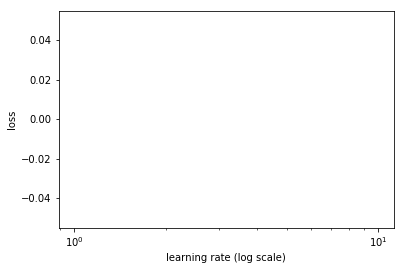

In [45]:
learn.lr_find()
learn.sched.plot()

In [45]:
# lr=1e-1
lr=1e-1
# lr=4e-3
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [46]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc                   
    0      0.427928   8.864902   0.48371   
 33%|███▎      | 6/18 [00:05<00:10,  1.09it/s, loss=0.338]

Process Process-26:
Process Process-27:
Process Process-23:
Process Process-24:
Process Process-22:
Process Process-28:
Process Process-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _w

In [48]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [49]:
learn.unfreeze()
learn.bn_freeze(True)

In [50]:
# lr=1e-1
lr=1e-2
# lr=4e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [51]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.031991   0.063641   0.975363  
    1      0.030572   0.060161   0.976149                   
    2      0.029785   0.06177    0.977997                   
    3      0.029223   0.061754   0.977693                   
    4      0.028725   0.061096   0.978387                   
    5      0.02841    0.061103   0.976776                   
    6      0.028121   0.060099   0.976964                   
    7      0.027827   0.060403   0.9784                     
    8      0.027631   0.060866   0.977871                   
    9      0.02749    0.060216   0.977485                   



[array([0.06022]), 0.9774846434593201]

In [53]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.027174   0.05975    0.976177  
    1      0.027111   0.058333   0.975461                   
    2      0.026888   0.059994   0.977134                   
    3      0.026614   0.061919   0.979278                   
    4      0.026378   0.05995    0.977742                   
    5      0.02621    0.061916   0.979626                   
    6      0.026053   0.061785   0.979319                   
    7      0.02585    0.062276   0.979614                   
    8      0.025708   0.060366   0.978835                   
    9      0.025538   0.062678   0.979375                   



[array([0.06268]), 0.9793750047683716]

In [54]:
learn.save(f'128urn-{S_PREFIX}-0')

In [89]:
learn.load(f'128urn-{S_PREFIX}-0')

In [55]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [56]:
py = np.argmax(py,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


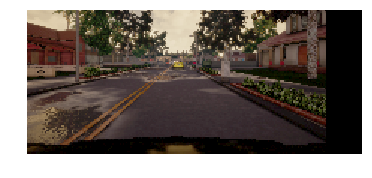

In [57]:
show_img(denorm(x[0]))

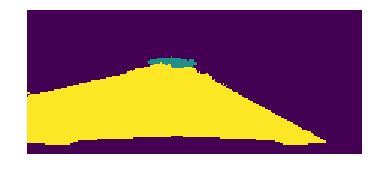

In [58]:
show_img(py[0]);

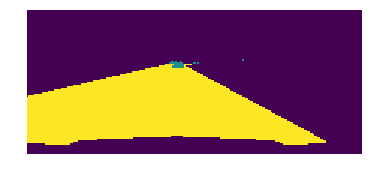

In [59]:
show_img(y[0]);

## 256x256

In [62]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz)

In [63]:
lr=1e-1
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [64]:
import gc
gc.collect()

8878

In [65]:
learn = get_learner(md)

In [66]:
learn.freeze_to(1)

 98%|█████████▊| 50/51 [00:17<00:00,  2.78it/s, loss=3.95] 

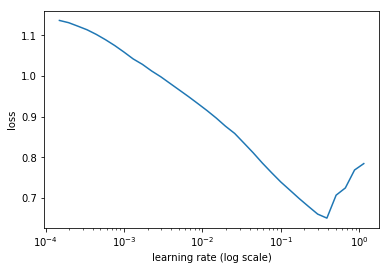

In [100]:
learn.lr_find()
learn.sched.plot()

In [67]:
learn.load(f'128urn-{S_PREFIX}-0')

In [68]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc                    
    0      0.054886   0.099366   0.985861  
    1      0.046843   0.094144   0.963508                   
    2      0.040891   0.058384   0.984273                   
    3      0.034808   0.044023   0.984954                   
    4      0.031716   0.150339   0.985274                   
    5      0.03192    0.047019   0.986713                   
    6      0.03028    0.042491   0.982987                   
    7      0.027905   0.036802   0.983598                   
    8      0.025538   0.041053   0.989324                   
    9      0.024044   0.039      0.988333                   



[array([0.039]), 0.9883334398269653]

In [69]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [70]:
learn.unfreeze()
learn.bn_freeze(True)

In [71]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [72]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                    
    0      0.021857   0.051916   0.990401  
    1      0.022305   0.045938   0.989172                   
    2      0.021601   0.038538   0.988968                   
    3      0.021236   0.042786   0.988371                   
    4      0.020628   0.041056   0.989217                   
    5      0.020069   0.04019    0.98962                    
    6      0.019587   0.041314   0.989455                   
    7      0.019164   0.041465   0.989823                   



[array([0.04147]), 0.9898232316970825]

In [73]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                    
    0      0.020129   0.043182   0.989974  
    1      0.0201     0.049032   0.989548                   
    2      0.022326   0.041959   0.989145                   
    3      0.020362   0.039046   0.989237                   
    4      0.019297   0.04132    0.989887                   
    5      0.018624   0.042673   0.990125                   
    6      0.018381   0.04112    0.989942                   
    7      0.018068   0.041612   0.990174                   



[array([0.04161]), 0.9901735043525696]

In [74]:
learn.save(f'256urn-{S_PREFIX}')

In [75]:
learn.load(f'256urn-{S_PREFIX}')

In [76]:
x,y = next(iter(md.trn_dl))

In [77]:
x.shape

torch.Size([64, 3, 192, 416])

In [78]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [79]:
py = np.argmax(py,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


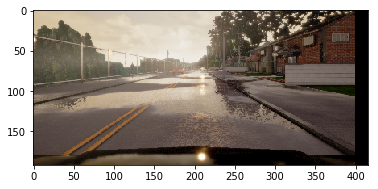

In [80]:
plt.imshow(denorm(x[-1]))

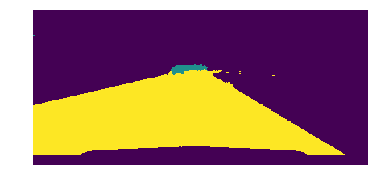

In [81]:
show_img(py[-1]);

In [82]:
py[-1].shape

(192, 416)

In [83]:
y[-1].shape

torch.Size([192, 416])

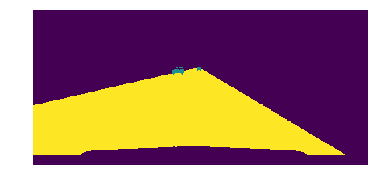

In [84]:
show_img(y[-1]);

## 512x512

In [40]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=24
md = torch_loader(ext, PATH, bs, sz)

learn = get_learner(md)

Valx: 300, Valy: 300
Trnx: 7980, Trny: 7980
Testx: 1000
Allx: 7280


 94%|█████████▍| 96/102 [00:53<00:03,  1.79it/s, loss=1.97] 

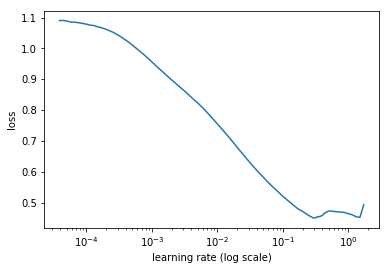

In [124]:
learn.lr_find()
learn.sched.plot()

In [94]:
learn.load(f'256urn-{S_PREFIX}')

In [95]:
learn.freeze_to(1)

In [41]:
lr=4e-2
wd=5e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [97]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc                      
    0      0.026151   0.02564    0.992936  
    1      0.026248   0.024307   0.99431                      
    2      0.018568   0.020553   0.995138                     
    3      0.015331   0.019149   0.995148                     



[array([0.01915]), 0.995147774219513]

In [98]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc                      
    0      0.022003   0.028092   0.992552  
    1      0.022396   0.0222     0.994848                     
    2      0.01794    0.019667   0.995205                     
    3      0.015426   0.018776   0.995292                     



[array([0.01878]), 0.9952917218208313]

In [99]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [42]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [43]:
learn.unfreeze()
learn.bn_freeze(True)

In [44]:
lrs = np.array([lr/200,lr/30,lr])

In [45]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                      
    0      0.013651   0.01935    0.99512   
    1      0.01353    0.018378   0.995339                     
    2      0.012987   0.018227   0.995523                     
    3      0.012885   0.018388   0.99548                      



[array([0.01839]), 0.9954802823066712]

In [47]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                      
    0      0.013957   0.018481   0.995524  
    1      0.012932   0.017943   0.995501                     
    2      0.01263    0.018145   0.995502                     
    3      0.012264   0.018161   0.995582                     



[array([0.01816]), 0.995582480430603]

In [ ]:
learn.sched.plot_loss()

In [39]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=32
md = torch_loader(ext, PATH, bs, sz)

learn = get_learner(md)

In [41]:
learn.load(f'600urn-{S_PREFIX}')

In [43]:
lr=4e-2
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [45]:
learn.fit(lrs/2,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                      
    0      0.020143   0.0142     0.995229  
    1      0.018669   0.013483   0.995438                     
    2      0.017642   0.013582   0.995162                     
    3      0.016649   0.013193   0.995577                     



[array([0.01319]), 0.9955773639678955]

In [47]:
learn.save(f'600urn-{S_PREFIX}-26-reboot')

In [48]:
learn.fit(lrs/20,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.017155   0.013198   0.995774  
    1      0.017275   0.01323    0.995526                     
    2      0.016587   0.013032   0.995687                     
    3      0.016331   0.013088   0.995593                     



[array([0.01309]), 0.9955930423736572]

In [51]:
learn.save(f'600urn-{S_PREFIX}-26-r2')

In [57]:
ext = ''
sz=384
bs=32
md = torch_loader(ext, PATH, bs, sz, random_crop=True)
learn = get_learner(md)

In [53]:
learn.load(f'600urn-{S_PREFIX}-26-r2')

### Trying random crop

In [58]:
learn.fit(lrs/4,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                     
    0      0.188719   0.119937   0.973261  
    1      0.079916   0.066886   0.979708                     
    2      0.063399   0.058659   0.984942                     
    3      0.059081   0.05318    0.984604                     


[array([0.05318]), 0.9846043038368225]

In [59]:
learn.save(f'600urn-{S_PREFIX}-26-r3-rrc')

In [40]:
ext = ''
sz=384
bs=32
md = torch_loader(ext, PATH, bs, sz)

learn = get_learner(md)

In [41]:
learn.load(f'600urn-{S_PREFIX}-26-r3-rrc')

In [44]:
learn.fit(lrs/4,1, wds=wd,cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.031342   0.037473   0.987393  
    1      0.028057   0.047555   0.9864                       
    2      0.027302   0.041253   0.986265                     
    3      0.024275   0.035961   0.987224                     
    4      0.022574   0.032247   0.989499                     
    5      0.020972   0.032217   0.988753                     
    6      0.018196   0.032061   0.989908                     
    7      0.016928   0.029523   0.989812                     



[array([0.02952]), 0.9898115674654643]

In [45]:
learn.save(f'600urn-{S_PREFIX}-26-r4')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [52]:
learn.fit(lrs/8,1, wds=wd,cycle_len=20,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                      
    0      0.011641   0.018316   0.995682  
    1      0.012915   0.019081   0.995652                     
    2      0.012145   0.01863    0.995772                     
    3      0.012335   0.018656   0.995591                     
    4      0.01163    0.018474   0.99552                      
    5      0.011376   0.018384   0.995531                     
    6      0.011235   0.018248   0.995411                     
    7      0.010998   0.017676   0.995552                     
    8      0.01106    0.017835   0.995643                     
    9      0.010799   0.017823   0.995648                     
    10     0.010727   0.017913   0.99582                      
    11     0.010499   0.017766   0.995822                     
    12     0.010641   0.018556   0.995834                     
    13     0.010462   0.018331   0.995786                     
    14     0.010386   0.01759    0.995793                     
    15     

[array([0.01774]), 0.995842251777649]

### Maybe we should unfreeze

In [42]:
ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz)
learn = get_learner(md)

Valx: 300, Valy: 300
Trnx: 7980, Trny: 7980
Testx: 1000
Allx: 7280


In [79]:
learn.load(f'600urn-{S_PREFIX}-26-r2')
learn.unfreeze()
learn.bn_freeze(True)

In [80]:
lr=4e-2
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [40]:
learn.fit(lrs/4,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.012586   0.012074   0.995276  
    1      0.012379   0.012206   0.995486                     
    2      0.010794   0.011791   0.995566                     
    3      0.010624   0.011405   0.9957                        



[array([0.01141]), 0.9957000645001729]

In [41]:
learn.save(f'600urn-{S_PREFIX}-26-r5')

In [42]:
learn.fit(lrs/10,1, wds=wd,cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                       
    0      0.009708   0.011364   0.995754  
    1      0.010311   0.011325   0.995793                      
    2      0.010523   0.011534   0.995683                      
    3      0.00959    0.01144    0.995573                      
    4      0.010883   0.011334   0.995636                      
    5      0.009855   0.011107   0.995937                      
    6      0.009666   0.010894   0.996019                      
    7      0.009102   0.01085    0.996005                      



[array([0.01085]), 0.9960046482086181]

In [43]:
learn.save(f'600urn-{S_PREFIX}-26-r6')

In [44]:
learn.unfreeze()
learn.bn_freeze(True)

In [45]:
learn.fit(lrs/80,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                       
    0      0.008698   0.010832   0.996061  
    1      0.008694   0.010898   0.995967                      
    2      0.008549   0.010832   0.996028                      
    3      0.008902   0.010786   0.996064                      



[array([0.01079]), 0.9960636250178019]

In [46]:
learn.save(f'600urn-{S_PREFIX}-26-r7')

In [44]:
learn.load(f'600urn-{S_PREFIX}-26-r7')

In [45]:
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs/40,1, wds=wd,cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.089059   0.014575   0.996045  
    1      0.047009   0.012769   0.996227                     
    2      0.028314   0.010301   0.996956                     
    3      0.019291   0.011133   0.996908                     
    4      0.016064   0.00847    0.997382                     
    5      0.012913   0.009686   0.997099                     
    6      0.013845   0.008754   0.997301                     
    7      0.012535   0.008131   0.997355                     



[array([0.00813]), 0.9973547037442525]

In [46]:
learn.save(f'600urn-{S_PREFIX}-26-r8')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs/20,1, wds=wd,cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.012389   0.008722   0.997278  
    1      0.012598   0.00754    0.997517                     
    2      0.010372   0.007152   0.997592                     
    3      0.013667   0.006899   0.997472                     
    4      0.010888   0.00629    0.997866                      
 87%|████████▋ | 432/499 [02:19<00:21,  3.09it/s, loss=0.00957]

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
plt.imshow(denorm(x[10]))

In [ ]:
show_img(py[10]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[10]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()